In [3]:
import csv
import pandas as pd
import matplotlib as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import r2_score as r2_score
from statsmodels.tsa.stattools import acf, pacf # for ACF and PACF plots:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import confusion_matrix
from sklearn import linear_model

# Import monthly subreddit data

In [8]:
monthly_subreddit = pd.read_csv('../data/monthly_subreddit_2013_14.csv');
monthly_subreddit_active = pd.read_csv('../data/monthly_subreddit_active_2013_14.csv');

In [9]:
def monthToString(month):
    if month <10:
        return '0'+str(month)
    else:
        return str(month)

In [10]:
subreddits_with_active_users_in_period =pd.DataFrame(monthly_subreddit_active.groupby(['subreddit']).agg('count').reset_index()[monthly_subreddit_active.groupby(['subreddit']).agg('count').reset_index().month==24].subreddit)


In [11]:
subreddit_content = pd.DataFrame({'yearmonth':monthly_subreddit.year.apply(monthToString)+monthly_subreddit.month.apply(monthToString), 'subreddit':monthly_subreddit.subreddit,'num_contributors':monthly_subreddit.num_posters+monthly_subreddit.num_commenters,'num_contributions':monthly_subreddit.num_posts+monthly_subreddit.num_comments})
subreddit_content_active = pd.DataFrame({'yearmonth':monthly_subreddit_active.year.apply(monthToString)+monthly_subreddit_active.month.apply(monthToString), 'subreddit':monthly_subreddit_active.subreddit,'num_contributors':monthly_subreddit_active.num_posters_active+monthly_subreddit_active.num_commenters_active,'num_contributions':monthly_subreddit_active.num_posts_active+monthly_subreddit_active.num_comments_active})

In [12]:
list_subreddits=subreddit_content.subreddit.unique()
list_subreddits_active=subreddit_content_active.subreddit.unique()

In [13]:
(list_subreddits.shape[0] == 137623) and (list_subreddits_active.shape[0] == 80173)

True

In [14]:
# There are 137623 unique subreddits in 2013-2014
# There are 80173 unique subreddits that active users participated in

# New data wrangling

In [15]:
monthly_subreddit_active_processed = pd.DataFrame({'date':pd.to_datetime(monthly_subreddit_active.year.apply(monthToString)+monthly_subreddit_active.month.apply(monthToString), format='%Y%m', errors='ignore'),'subreddit':monthly_subreddit_active.subreddit,'num_contributors':monthly_subreddit_active.num_posters_active+monthly_subreddit_active.num_commenters_active,'score':monthly_subreddit_active.total_post_score_active+monthly_subreddit_active.total_comment_score_active,'num_char':monthly_subreddit_active.total_title_length_active+monthly_subreddit_active.total_body_length_active,'num_gold':monthly_subreddit_active.num_gold_active,'num_controversial':monthly_subreddit_active.num_controversiality_active,'num_stickied':monthly_subreddit_active.num_stickied_active,'num_quarantine':monthly_subreddit_active.num_quarantine_active,'num_moderators':monthly_subreddit_active.num_moderators_active})


In [16]:
def get_ts(subreddit):
    return monthly_subreddit_active_processed[monthly_subreddit_active_processed.subreddit==subreddit].drop('subreddit', axis=1).sort_values('date').set_index('date')

In [17]:
def shift_exogenous_features(ts):
    df = pd.DataFrame({'num_contributors':ts['num_contributors']})
    return df.join(ts.drop('num_contributors',axis=1).set_index(ts.index+pd.DateOffset(months=1)),how='outer')

In [18]:
# function to invert the exponentially weighted moving average

def invert_ewma(ewma_series):
    output = [ewma_series[0]]
    w = []
    alpha = 1-np.exp(np.log(0.5)/12)
    w = [(1-alpha)**i for i in range(len(ewma_series))]
    for x in range(1,len(ewma_series)):
        output.append((sum(w[:x+1])*ewma_series[x]-sum([w[i]*output[x-i] for i in range(1,x+1)])))
    return pd.Series(output,index=ewma_series.index)

In [13]:
time_series = get_ts('tifu')
shifted_time_series = shift_exogenous_features(time_series)

In [19]:
top_subreddits = subreddit_content_active.subreddit.ix[subreddit_content_active.groupby('yearmonth')['num_contributions'].apply(lambda x: x.nlargest(100)).reset_index().level_1.unique().tolist()].unique()

bad_subreddits = []

In [15]:
top_subreddits.shape

(271,)

In [20]:
class ConfusionMatrix:
    def __init__(self):
        self.matrix = np.zeros((3,3))
        
    def class_of_growth(self,series,series_pred,k):
        '''Determines if the last data point fluctuates more than a std deviation from the last value'''
        #k = 1.0 #
        delta = series[:-3].std()
        baseline = series[-5:-3].mean()
        # baseline = series[-4]
        if series_pred[-1] < baseline-k*delta:
            return np.array([[1,0,0]])
        elif series_pred[-1] > baseline+k*delta:
            return np.array([[0,0,1]])
        else:
            return np.array([[0,1,0]])
    
    def update_matrix(self, actual, predicted,k):
        self.matrix += (self.class_of_growth(1.0*actual,actual,k).transpose())*self.class_of_growth(actual,1.0*predicted,k)

def add_ones(df):
    const_df = pd.DataFrame({'const':np.ones(len(df))},index=df.index)
    return pd.concat([const_df,df],axis=1)

    

In [21]:
## Trying to get this right

In [20]:
ts = get_ts('movies').num_contributors

In [ ]:
# Take the log to flatten out the time series

In [111]:
ts_log = np.log(ts)

In [ ]:
# compute the exponential moving average

In [122]:
ts_log_ewma = ts_log.ewm(halflife=12).mean()

In [123]:
# Now, we compute the seasonal effects

In [156]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [246]:
ts_log_ewma_s = ts_log_ewma-seasonal

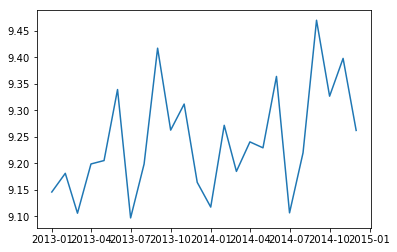

In [247]:
plt.plot(ts_log_ewma_s)

In [ ]:
# Subtract the trend

In [296]:
regr = linear_model.LinearRegression()

In [438]:
X = [i for i in range(0, len(ts_log_ewma))]
X = np.reshape(X, (len(X), 1))

In [439]:
regr.fit(X[:21],ts_log_ewma_s.values[:21].reshape(21,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [440]:
model_trend = regr.predict(X)

In [302]:
ts_log_ewma_st = ts_log_ewma_s-model_trend.reshape(24,)

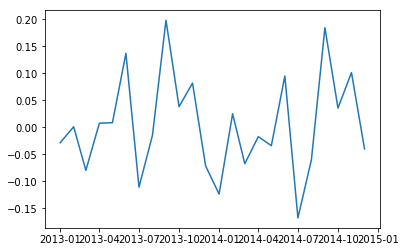

In [303]:
plt.plot(ts_log_ewma_st)

In [304]:
lag_acf = acf(ts_log_ewma_st, nlags=20)
lag_pacf = pacf(ts_log_ewma_st, nlags=20, method='ols')

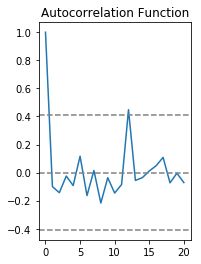

In [305]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

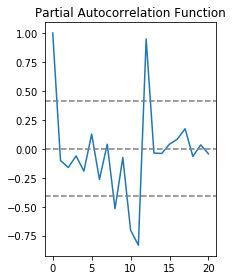

In [306]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
# Trying without subtracting seasonal trend

In [442]:
ts_log_ewma_t = ts_log_ewma-model_trend.reshape(24,)

In [449]:
lag_acf = acf(ts_log_ewma_t, nlags=20)
lag_pacf = pacf(ts_log_ewma_t, nlags=20, method='ols')

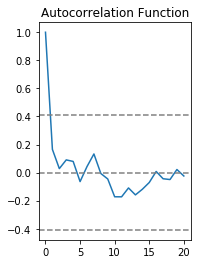

In [450]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

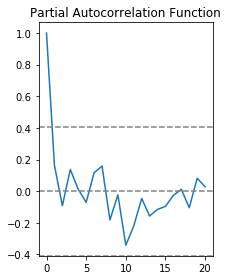

In [451]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [455]:
results_ARIMA.fittedvalues[21:]

date
2014-10-01    0.007288
2014-11-01   -0.001324
2014-12-01    0.010959
dtype: float64

In [ ]:
# No seasonal

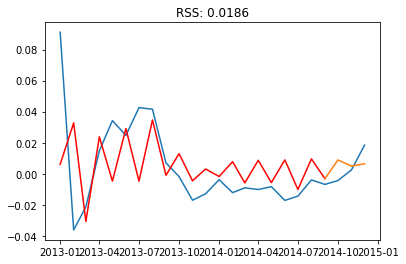

In [481]:
model = ARIMA(ts_log_ewma_t, order=(1, 0, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_ewma_t)
plt.plot(results_ARIMA.fittedvalues[:21], color='red')
plt.plot(ts_log_ewma_t.index[20:],np.insert(results_ARIMA.forecast(steps=3)[0],0,results_ARIMA.fittedvalues[20]))
#plt.plot(model_prediction)
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_ewma_t)**2))

In [464]:
model_prediction = np.insert(results_ARIMA.forecast(steps=3)[0],0,results_ARIMA.fittedvalues[:21])
model_prediction_inverted = invert_ewma(pd.Series(model_prediction,index=ts_log_ewma_st.index)+model_trend.reshape(24,))


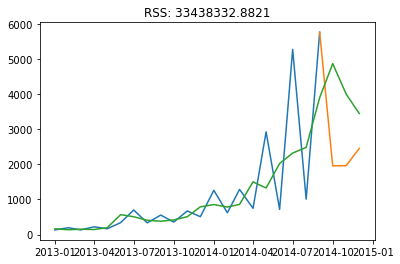

In [703]:
plt.plot(np.exp(model_prediction_inverted)[:21])
plt.plot(np.exp(model_prediction_inverted)[20:])
#plt.plot(np.exp(ts_log))
#plt.plot(np.exp(invert_ewma(ts_log_ewma)))
plt.plot(ts)
#plt.plot(np.exp(invert_ewma(model_trend.reshape(24,)+seasonal+ts_log_ewma_st)))
#plt.plot(np.exp(model_trend.reshape(24,)+seasonal))
plt.title('RSS: %.4f'% sum((np.exp(model_prediction_inverted)-ts)**2))

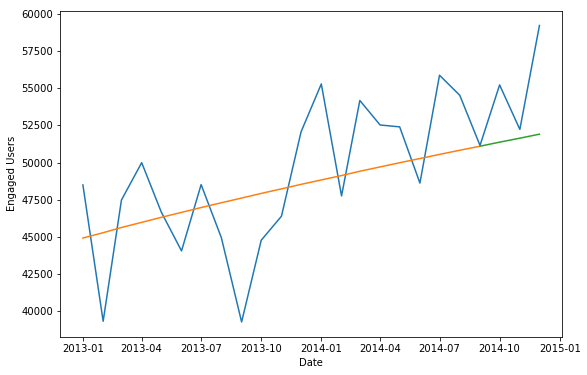

In [23]:
# SINGLE ARMA model with plot

sName = 'AskReddit'
ts = get_ts(sName).num_contributors
ts_log = np.log(ts)
ts_log_ewma = ts_log.ewm(halflife=12).mean()

regr = linear_model.LinearRegression()
X = [i for i in range(0, len(ts_log_ewma))]
X = np.reshape(X, (len(X), 1))
regr.fit(X[:21],ts_log_ewma.values[:21].reshape(21,1))
model_trend = regr.predict(X)

ts_exog =get_ts(sName).num_char.shift(-1)
ts_exog_log = np.log(ts_exog)
ts_exog_log_ewma = ts_exog_log.ewm(halflife=12).mean()

regrE = linear_model.LinearRegression()
regrE.fit(X[:21],ts_exog_log_ewma.values[:21].reshape(21,1))
model_exog_trend = regrE.predict(X)

ts_exog_log_ewma_t = ts_exog_log_ewma-model_exog_trend.reshape(24,)

ts_log_ewma_t = ts_log_ewma-model_trend.reshape(24,)
model = ARIMA(ts_log_ewma_t[:21], order=(1, 0, 1))#,exog = ts_exog_log_ewma_t[:21])  
results_ARIMA = model.fit(disp=-1)  

model_prediction = np.insert(results_ARIMA.forecast(steps=3)[0],0,results_ARIMA.fittedvalues[:21])
model_prediction_inverted = invert_ewma(pd.Series(model_prediction,index=ts_log_ewma_t.index)+model_trend.reshape(24,))
ts_predicted = np.exp(model_prediction_inverted)

plt.figure(figsize=(9,6))
plt.plot(ts)
plt.plot(ts_predicted[:21])
plt.plot(ts_predicted[20:])
plt.ylabel('Engaged Users')
plt.xlabel('Date')
#plt.title('Engaged Users vs Date in the "'+sName + '" subreddit')
#plt.title('RSS: %.4f'% sum((np.exp(model_prediction_inverted)-ts)**2))

# Now to get the ARMA(1,1) model working in a loop

In [35]:
cf_matrix = ConfusionMatrix()
num_nonstationary = 0
num_incomplete = 0
for x in top_subreddits:
    ts = get_ts(x).num_contributors
    if len(ts) == 24:
        ts_log = np.log(ts)
        ts_log_ewma = ts_log.ewm(halflife=12).mean()
        
        regr = linear_model.LinearRegression()
        X = [i for i in range(0, len(ts_log_ewma))]
        X = np.reshape(X, (len(X), 1))
        regr.fit(X[:21],ts_log_ewma.values[:21].reshape(21,1))
        model_trend = regr.predict(X)
        
        ts_log_ewma_t = ts_log_ewma-model_trend.reshape(24,)
        
        model = ARIMA(ts_log_ewma_t[:21], order=(1, 0, 1))  

        try:
            results_ARIMA = model.fit(disp=-1)  

            model_prediction = np.insert(results_ARIMA.forecast(steps=3)[0],0,results_ARIMA.fittedvalues[:21])
            model_prediction_inverted = invert_ewma(pd.Series(model_prediction,index=ts_log_ewma_t.index)+model_trend.reshape(24,))
            ts_predicted = np.exp(model_prediction_inverted)
            
            cf_matrix.update_matrix(ts,ts_predicted,1)
            '''
            plt.figure(figsize=(15,8))
            plt.plot(ts)
            plt.plot(ts_predicted[:21])
            plt.plot(ts_predicted[20:])
            plt.ylabel('# Engaged Users')
            plt.xlabel('Date')
            plt.title('Time Series for # Engaged Users in Subreddit '+ x)
            '''
        except:
            num_nonstationary += 1
            #print(x, ' is not stationary ')

print(cf_matrix.matrix)
print('Number of nonstationary is ',num_nonstationary)
print('Number of incomplete is ',num_incomplete)

/Users/Tom/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[[  5.  11.   4.]
 [ 12.  55.  39.]
 [  4.  22.   9.]]
('Number of nonstationary is ', 35)
('Number of incomplete is ', 0)


In [36]:
cf_matrix.matrix.trace()/(cf_matrix.matrix.sum())

0.42857142857142855

In [38]:
(cf_matrix.matrix.sum())

161.0

In [39]:
cf_matrix.matrix[:,1]

array([ 11.,  55.,  22.])

#  ARMAX(1,1): Adding the exogenous features

In [23]:
date_labels = ['Jan 13','Feb 13','Mar 13','Apr 13','May 13', 'Jun 13', 'July 13', 'Aug 13', 'Sep 13', 'Oct 13', 'Nov 13', 'Dec 13', 'Jan 14','Feb 14','Mar 14','Apr 14','May 14', 'Jun 14', 'July 14', 'Aug 14', 'Sep 14', 'Oct 13', 'Nov 14']

/Users/Tom/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log
/Users/Tom/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.89774116994524511

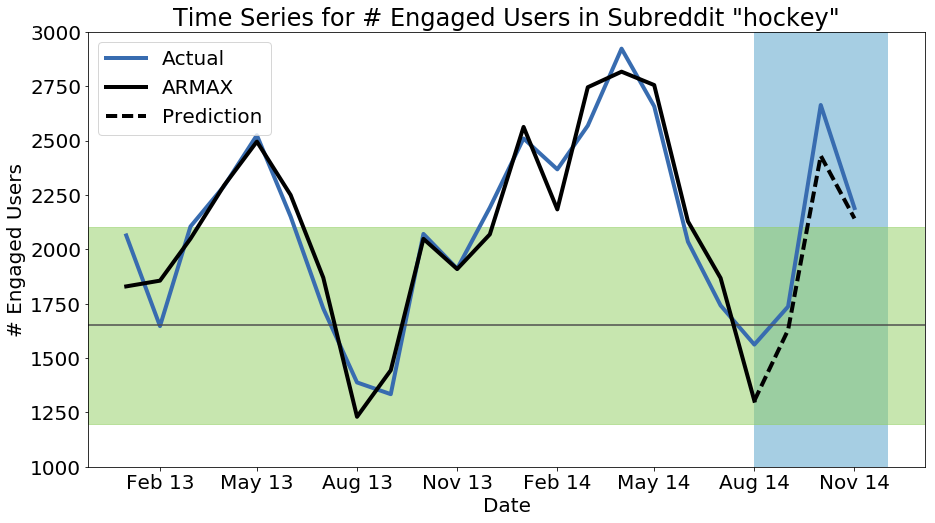

In [162]:
x = 'hockey'
cf_matrix = ConfusionMatrix()
ts = get_ts(x).num_contributors
# Here we are dealing with the entire time series
ts_log = np.log(ts)
ts_log_ewma = ts_log.ewm(halflife=12).mean()

# We want to fit 2013-02->2014-08 and Project the trend forward so we can 
# add the trend back after running the autoregressive model
regr = linear_model.LinearRegression()
X = [i for i in range(0, ts.shape[0])]
X = np.reshape(X, (len(X), 1))

regr.fit(X[1:20],ts_log_ewma.values[1:20].reshape(19,1))
y_linear_trend = regr.predict(X).reshape(24,)
        
ts_log_ewma_t = ts_log_ewma-y_linear_trend

# Train with 2013-02->2014-08
ts_training = ts_log_ewma_t[1:20]

# Now let's get the exogenous features
exog_ts = get_ts(x)[['num_char','num_moderators','score']]
exog_ts_log = np.log(exog_ts)

# Exponentially smoothing the exogenous feature data
exog_ts_log_ewma = exog_ts_log.ewm(halflife=12).mean()

# Shifting the features so that we are predicting the future value of the number of engaged users
# with the current month of data
exog_ts_log_ewma_shifted = pd.DataFrame(exog_ts_log_ewma.shift(1)[1:]).set_index(ts.index[:-1])


exog_ts_log_ewma_shifted_training = exog_ts_log_ewma_shifted[1:20] 
exog_ts_log_ewma_shifted_test = exog_ts_log_ewma_shifted[20:23]

#Each of these is a DataFrame containing the trend
exog_trends = pd.concat([pd.DataFrame({feat:regr.fit(X[1:20],exog_ts_log_ewma_shifted_training[feat].values.reshape(19,1)).predict(X).reshape(24,)},index=ts.index) for feat in exog_ts_log_ewma_shifted],axis=1)
exog_trend_test = exog_trends[20:-1]
exog_trend_training = exog_trends[1:20]

#Subtracting the trend
exog_training = exog_ts_log_ewma_shifted_training-exog_trend_training
exog_test = exog_ts_log_ewma_shifted_test-exog_trend_test

model = ARIMA(ts_training, order=(1, 0, 1),exog = exog_training)
#exog_ts

results_ARIMA = model.fit(disp=-1)  

ts_forecast = results_ARIMA.forecast(steps=3,exog=exog_test)[0]
#model_prediction = np.insert(ts_forecast,0,results_ARIMA.fittedvalues[:21])
model_prediction = np.insert(np.insert(ts_forecast,0,results_ARIMA.fittedvalues),0,ts_training[0])
model_prediction_inverted = invert_ewma(pd.Series(model_prediction,index=ts.index[:-1])+y_linear_trend[:-1].reshape(23,))
ts_predicted = np.exp(model_prediction_inverted)

cf_matrix.update_matrix(ts,ts_predicted,1)
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 20})
plt.ylim([1000,3000])
plt.plot(ts[:-1],linewidth=4,label='Actual',color='#386cb0')
plt.axvspan(ts.index[-5], ts.index[-1], alpha=1, color='#a6cee3')
plt.axhline(y=(ts[18]+ts[19])/2.0,color='#4d4d4d')
plt.axhspan((ts[18]+ts[19])/2.0-ts_predicted[:-3].std(), (ts[18]+ts[19])/2.0+ts_predicted[:-3].std(), alpha=0.5, color='#91cf60')
plt.plot(ts_predicted[:20],linewidth=4,label='ARMAX',color='black')
plt.plot(ts_predicted[19:23],'--',linewidth=4,color='black',label='Prediction')
plt.ylabel('# Engaged Users')
plt.xlabel('Date')
plt.xticks(ts[:-1].index[1:][::3],date_labels[1:][::3])#, rotation='vertical')
plt.legend()
plt.title('Time Series for # Engaged Users in Subreddit "' +x+'"')

r2_score(ts[:20],ts_predicted[:-3])

In [ ]:
#plt.axhline(y=(ts[18]+ts[19])/2.0+ts_predicted[:-3].std(),color='gray').set_linestyle('--')
#plt.axhline(y=(ts[18]+ts[19])/2.0-ts_predicted[:-3].std(),color='gray').set_linestyle('--')

In [42]:
get_ts('AskReddit')[['num_contributors','num_char','num_moderators']].corr()

,num_contributors,num_char,num_moderators
num_contributors,1.000000,0.880263,0.679447
num_char,0.880263,1.000000,0.881626
num_moderators,0.679447,0.881626,1.000000


In [43]:
r2_score(ts[:-1],ts_predicted)

0.89245853841120515

In [116]:
ts_predicted[:-3].std()

453.002040261281

# Now, ARMAX in a loop

In [35]:
cf_matrix = ConfusionMatrix()
num_nonstationary = 0
num_incomplete = 0
for x in top_subreddits:
    ts = get_ts(x).num_contributors
    if len(ts) == 24:
        # Here we are dealing with the entire time series
        ts_log = np.log(ts)
        ts_log_ewma = ts_log.ewm(halflife=12).mean()

        # We want to fit 2013-02->2014-08 and Project the trend forward so we can 
        # add the trend back after running the autoregressive model
        regr = linear_model.LinearRegression()
        X = [i for i in range(0, ts.shape[0])]
        X = np.reshape(X, (len(X), 1))

        regr.fit(X[1:20],ts_log_ewma.values[1:20].reshape(19,1))
        y_linear_trend = regr.predict(X).reshape(24,)

        ts_log_ewma_t = ts_log_ewma-y_linear_trend

        # Train with 2013-02->2014-08
        ts_training = ts_log_ewma_t[1:20]

        # Now let's get the exogenous features
        exog_ts = get_ts(x)[['num_char','num_moderators','score']]
        exog_ts = exog_ts+1 # This is added because we will be taking the log and there are some zeros
        exog_ts_log = np.log(exog_ts)

        # Exponentially smoothing the exogenous feature data
        exog_ts_log_ewma = exog_ts_log.ewm(halflife=12).mean()

        # Shifting the features so that we are predicting the future value of the number of engaged users
        # with the current month of data
        exog_ts_log_ewma_shifted = pd.DataFrame(exog_ts_log_ewma.shift(1)[1:]).set_index(ts.index[:-1])


        exog_ts_log_ewma_shifted_training = exog_ts_log_ewma_shifted[1:20] 
        exog_ts_log_ewma_shifted_test = exog_ts_log_ewma_shifted[20:23]

        #Each of these is a DataFrame containing the trend
        [exog_ts_log_ewma_shifted_training[feat].values.reshape(19,1) for feat in exog_ts_log_ewma_shifted]
        [pd.DataFrame({feat:regr.fit(X[1:20],exog_ts_log_ewma_shifted_training[feat].values.reshape(19,1)).predict(X).reshape(24,)},index=ts.index) for feat in exog_ts_log_ewma_shifted]
        exog_trends = pd.concat([pd.DataFrame({feat:regr.fit(X[1:20],exog_ts_log_ewma_shifted_training[feat].values.reshape(19,1)).predict(X).reshape(24,)},index=ts.index) for feat in exog_ts_log_ewma_shifted],axis=1)
        exog_trend_test = exog_trends[20:-1]
        exog_trend_training = exog_trends[1:20]

        #Subtracting the trend
        exog_training = exog_ts_log_ewma_shifted_training-exog_trend_training
        exog_test = exog_ts_log_ewma_shifted_test-exog_trend_test

        model = ARIMA(ts_training, order=(1, 0, 1),exog = exog_training)  

        try:
            results_ARIMA = model.fit(disp=-1)  

            ts_forecast = results_ARIMA.forecast(steps=3,exog=exog_test)[0]
            model_prediction = np.insert(np.insert(ts_forecast,0,results_ARIMA.fittedvalues),0,ts_training[0])
            model_prediction_inverted = invert_ewma(pd.Series(model_prediction,index=ts.index[:-1])+y_linear_trend[:-1].reshape(23,))
            ts_predicted = np.exp(model_prediction_inverted)

            cf_matrix.update_matrix(ts,ts_predicted,1)
            #plt.figure(figsize=(15,8))
            #plt.plot(ts[:-1])
            #plt.plot(ts_predicted[19:23])
            #plt.plot(ts_predicted[:20])
            #plt.ylabel('# Engaged Users')
            #plt.xlabel('Date')
            #plt.title('Time Series for # Engaged Users in Subreddit ' +x)
        except:
            num_nonstationary += 1
            #print(x, ' is not stationary ')

print(cf_matrix.matrix)
print('Number of nonstationary is ',num_nonstationary)
print('Number of incomplete is ',num_incomplete)

/Users/Tom/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Tom/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Tom/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Tom/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Tom/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check m

[[ 10.   5.   0.]
 [ 12.  82.   7.]
 [  1.  17.  10.]]
('Number of nonstationary is ', 52)
('Number of incomplete is ', 0)


In [ ]:
# Trying different k's (used to define growth as a fraction of std deviation)

In [ ]:
# k=1.5

In [98]:
cf_matrix.matrix

array([[   6.,    0.,    0.],
       [   8.,  110.,    6.],
       [   0.,    9.,    5.]])

In [99]:
cf_matrix.matrix.trace()/cf_matrix.matrix.sum()

0.84027777777777779

In [ ]:
# k = 1.0

In [103]:
cf_matrix.matrix

array([[ 10.,   5.,   0.],
       [ 12.,  82.,   7.],
       [  1.,  17.,  10.]])

In [102]:
cf_matrix.matrix.trace()/cf_matrix.matrix.sum()

0.70833333333333337

In [112]:
# k = 0.75

In [113]:
cf_matrix.matrix

array([[ 15.,   6.,   1.],
       [ 17.,  58.,  11.],
       [  4.,  17.,  15.]])

In [114]:
cf_matrix.matrix.trace()/cf_matrix.matrix.sum()

0.61111111111111116

In [ ]:
# k = 0.5

In [106]:
cf_matrix.matrix

array([[ 19.,   6.,   3.],
       [ 16.,  43.,   9.],
       [ 11.,  15.,  22.]])

In [107]:
cf_matrix.matrix.trace()/cf_matrix.matrix.sum()

0.58333333333333337

In [45]:
r2_score(ts[:20],ts_predicted[:-3])

0.96157902008874241

In [6]:
cf = np.array([[ 10.,   5.,   0.],
       [ 12.,  82.,   7.],
       [  1.,  17.,  10.]])

In [147]:
plot_confusion_matrix(cf, ['Shrinking','Constant','growing'],
                      title='Confusion Matrix')

NameError: name 'plot_confusion_matrix' is not defined

In [53]:
cf_matrix.matrix[:][0]/cf_matrix.matrix[:][0].sum()

array([ 0.66666667,  0.33333333,  0.        ])

In [56]:
accuracy_by_type=[cf_matrix.matrix[:][i]/cf_matrix.matrix[:][i].sum() for i in [0,1,2]]

<Container object of 3 artists>

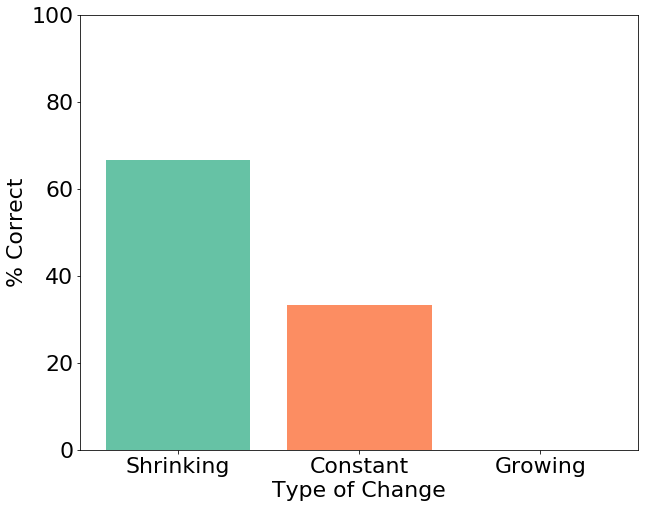

In [149]:
plt.figure(figsize=(10,8))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})
plt.ylabel('% Correct')
plt.xlabel('Type of Change')
plt.ylim([0,100])
#plt.title('Shrinking Subreddits')
plt.bar([1,2,3],100*accuracy_by_type[0],tick_label=['Shrinking','Constant','Growing'],color=['#66c2a5','#fc8d62','#8da0cb'])

<Container object of 3 artists>

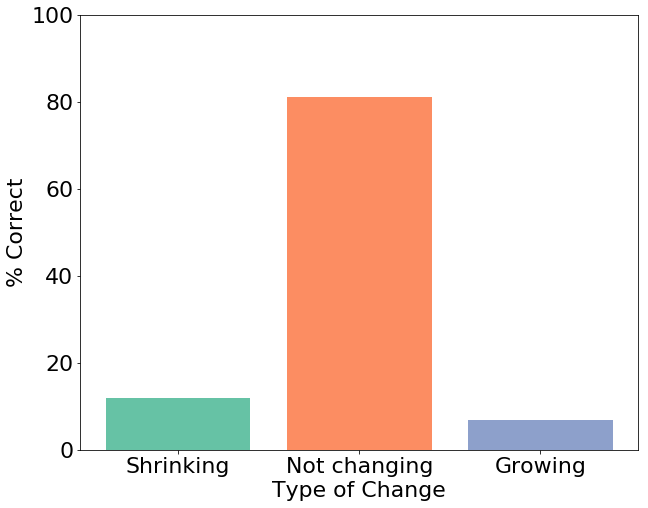

In [150]:
plt.figure(figsize=(10,8))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})
plt.ylabel('% Correct')
plt.ylim([0,100])
plt.xlabel('Type of Change')
#plt.title('Constant Subreddits')
plt.bar([1,2,3],100*accuracy_by_type[1],tick_label=['Shrinking','Not changing','Growing'],color=['#66c2a5','#fc8d62','#8da0cb'])

<Container object of 3 artists>

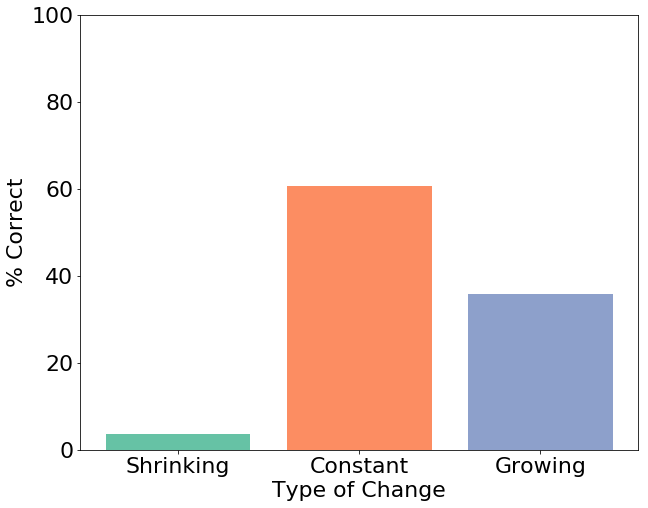

In [151]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 22})
plt.ylabel('% Correct')
plt.xlabel('Type of Change')
#plt.title('Growing Subreddits')
plt.ylim([0,100])
plt.bar([1,2,3],100*accuracy_by_type[2],tick_label=['Shrinking','Constant','Growing'],color=['#66c2a5','#fc8d62','#8da0cb'])

In [152]:
top_top_subreddits = subreddit_content_active.subreddit.ix[subreddit_content_active.groupby('yearmonth')['num_contributions'].apply(lambda x: x.nlargest(1000)).reset_index().level_1.unique().tolist()].unique()


In [156]:
top_top_subreddits.shape

(2304,)

In [157]:
cf_matrix = ConfusionMatrix()
num_nonstationary = 0
num_incomplete = 0
for x in top_top_subreddits:
    ts = get_ts(x).num_contributors
    if len(ts) == 24:
        # Here we are dealing with the entire time series
        ts_log = np.log(ts)
        ts_log_ewma = ts_log.ewm(halflife=12).mean()

        # We want to fit 2013-02->2014-08 and Project the trend forward so we can 
        # add the trend back after running the autoregressive model
        regr = linear_model.LinearRegression()
        X = [i for i in range(0, ts.shape[0])]
        X = np.reshape(X, (len(X), 1))

        regr.fit(X[1:20],ts_log_ewma.values[1:20].reshape(19,1))
        y_linear_trend = regr.predict(X).reshape(24,)

        ts_log_ewma_t = ts_log_ewma-y_linear_trend

        # Train with 2013-02->2014-08
        ts_training = ts_log_ewma_t[1:20]

        # Now let's get the exogenous features
        exog_ts = get_ts(x)[['num_char','num_moderators','score']]
        exog_ts = exog_ts+1 # This is added because we will be taking the log and there are some zeros
        exog_ts_log = np.log(exog_ts)

        # Exponentially smoothing the exogenous feature data
        exog_ts_log_ewma = exog_ts_log.ewm(halflife=12).mean()

        # Shifting the features so that we are predicting the future value of the number of engaged users
        # with the current month of data
        exog_ts_log_ewma_shifted = pd.DataFrame(exog_ts_log_ewma.shift(1)[1:]).set_index(ts.index[:-1])


        exog_ts_log_ewma_shifted_training = exog_ts_log_ewma_shifted[1:20] 
        exog_ts_log_ewma_shifted_test = exog_ts_log_ewma_shifted[20:23]

        #Each of these is a DataFrame containing the trend
        [exog_ts_log_ewma_shifted_training[feat].values.reshape(19,1) for feat in exog_ts_log_ewma_shifted]
        [pd.DataFrame({feat:regr.fit(X[1:20],exog_ts_log_ewma_shifted_training[feat].values.reshape(19,1)).predict(X).reshape(24,)},index=ts.index) for feat in exog_ts_log_ewma_shifted]
        exog_trends = pd.concat([pd.DataFrame({feat:regr.fit(X[1:20],exog_ts_log_ewma_shifted_training[feat].values.reshape(19,1)).predict(X).reshape(24,)},index=ts.index) for feat in exog_ts_log_ewma_shifted],axis=1)
        exog_trend_test = exog_trends[20:-1]
        exog_trend_training = exog_trends[1:20]

        #Subtracting the trend
        exog_training = exog_ts_log_ewma_shifted_training-exog_trend_training
        exog_test = exog_ts_log_ewma_shifted_test-exog_trend_test

        model = ARIMA(ts_training, order=(1, 0, 1),exog = exog_training)  

        try:
            results_ARIMA = model.fit(disp=-1)  

            ts_forecast = results_ARIMA.forecast(steps=3,exog=exog_test)[0]
            model_prediction = np.insert(np.insert(ts_forecast,0,results_ARIMA.fittedvalues),0,ts_training[0])
            model_prediction_inverted = invert_ewma(pd.Series(model_prediction,index=ts.index[:-1])+y_linear_trend[:-1].reshape(23,))
            ts_predicted = np.exp(model_prediction_inverted)

            cf_matrix.update_matrix(ts,ts_predicted,1)
            #plt.figure(figsize=(15,8))
            #plt.plot(ts[:-1])
            #plt.plot(ts_predicted[19:23])
            #plt.plot(ts_predicted[:20])
            #plt.ylabel('# Engaged Users')
            #plt.xlabel('Date')
            #plt.title('Time Series for # Engaged Users in Subreddit ' +x)
        except:
            num_nonstationary += 1
            #print(x, ' is not stationary ')

print(cf_matrix.matrix)
print('Number of nonstationary is ',num_nonstationary)
print('Number of incomplete is ',num_incomplete)

/Users/Tom/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Tom/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Tom/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Tom/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Tom/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to conver

[[  53.   37.    1.]
 [  89.  447.   73.]
 [  17.  121.   76.]]
('Number of nonstationary is ', 569)
('Number of incomplete is ', 0)


In [158]:
cf_matrix.matrix.sum()

914.0

In [159]:
accuracy_by_type=[cf_matrix.matrix[:][i]/cf_matrix.matrix[:][i].sum() for i in [0,1,2]]

In [160]:
accuracy_by_type

[array([ 0.58241758,  0.40659341,  0.01098901]),
 array([ 0.14614122,  0.73399015,  0.11986864]),
 array([ 0.07943925,  0.56542056,  0.35514019])]